# ⭐️ Experiments with TabPFN

It is recommended to run this notebook in Colab environment.

The notebook under Colab environment: https://colab.research.google.com/drive/1S9i1o-kvCWtUDNY7kDj0AAR88KAaJCEo#scrollTo=zJd6GvvQrwlh

In this notebook, we run experiments within the framework of the thesis *'Еnhancing early detection and mitagating bias in woman’s health through causal machine learning'*.

All experiments involving the TabPFN model are conducted here, as it provides a convenient and cost-effective environment for utilizing GPU acceleration, allowing for faster experimentation.

To enable GPUs for the notebook:

- Navigate to [Runtime] -> [Change runtime type]
- Select GPU from the drop-down

Install all the required packages.

In [ ]:
!pip install scikit-learn==1.5.2

!pip install tabpfn

!git clone https://github.com/PriorLabs/tabpfn-community
!pip install -e tabpfn-community[post_hoc_ensembles,interpretability,hpo]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s et

In [ ]:
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions[post_hoc_ensembles,interpretability,hpo]

Cloning into 'tabpfn-extensions'...
remote: Enumerating objects: 1777, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 1777 (delta 147), reused 154 (delta 101), pack-reused 1496 (from 1)
Receiving objects: 100% (1777/1777), 697.30 KiB | 2.13 MiB/s, done.
Resolving deltas: 100% (1072/1072), done.
Obtaining file:///content/tabpfn-extensions
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tabpfn-extensions (pyproject.toml) ... done
  Created wheel for tabpfn-extensions: filename=tabpfn_extensions-0.1.0-0.editable-py3-none-any.whl size=11669 sha256=97010d5aa411d1101a030f5751f7d5c571bd207cfb22b23b50bbb2ea48f40ea8
  Stored in directory: /tmp/pip-ephem-wheel-cache-men936u7/wheels/8f/b7/2c/ec18b502697068b39e1503426a50b729bdac046bed4810759d
Suc

After all the required packages are installed, please restart the session ([Runtime] -> [Restart session]).

Import all the required packages.

Also, please upload preprocessing.py, experiments_utils.py and feature_selection.py files to Colab Files environment




In [ ]:
import os
import pickle

import numpy as np
import pandas as pd
import shap
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split

if os.path.exists('tabpfn-community'):
  os.rename('tabpfn-community', 'tabpfn_community')

from tabpfn import TabPFNClassifier
from tabpfn_community.src.tabpfn_extensions.interpretability import shap as tabpfn_shap

from preprocessing import impute_features
import experiments_utils
import feature_selection

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU.')

In [ ]:
np.random.seed(42)

Please upload the preprocessed dataset.

Load the dataset.

In [ ]:
endo_data_path = "/content/preds_preprocessed_endo_data.csv"
df_endo = pd.read_csv(endo_data_path)

## Helper Functions for running TabPFN

Similar function defined in feature_selection.py. The only difference is that the functions below are specifically tailored for TabPGN.

In [ ]:
def run_tabPFN(X_train, y_train):
    tab_PFN_classifier = TabPFNClassifier(random_state=42).fit(X_train, y_train)
    return tab_PFN_classifier

In [ ]:
def predict_tabPFN(tab_PFN_classifier, X_test, y_test, disp=False):
  y_pred = tab_PFN_classifier.predict_proba(X_test)
  y_pred = (y_pred[:, 1] > 0.5).astype(int) if len(np.unique(y_test)) <= 2 else np.argmax(y_pred, axis=1)
  cm, acc, recall, specificity, f1 = feature_selection.evaluate_model(y_test, y_pred)
  if disp:
    print(f"\nTest Set Metrics:")
    feature_selection.print_confusion_metrics(cm, acc, recall, specificity, f1)
  return f1

In [ ]:
def cross_val_tabPFN(X, y, n_splits=5, disp=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_metrics_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        tabPFN_cv = run_tabPFN(X_train, y_train)
        f1_score = predict_tabPFN(tabPFN_cv, X_val, y_val)

        f1_metrics_list.append(f1_score)

    avg_f1_score = sum(f1_metrics_list) / len(f1_metrics_list)
    if disp:
      print(f"Avg F1 Score: {avg_f1_score}")

    final_tabPFN = run_tabPFN(X, y)

    return final_tabPFN, avg_f1_score

In [ ]:
def run_tabPFN_on_top_features(X_train, y_train, X_test, top_features, add_effects=False, min_features=None, max_features=None):

    models = {
        "TabPFN": (cross_val_tabPFN, []),
    }

    best_model, best_X_test, best_f1 = None, None, None

    min_features = min_features if min_features else 5
    max_features = max_features if max_features else len(top_features)

    for n_top_features in range(5, max_features, 1):
        if isinstance(top_features, pd.DataFrame) and"feature" in top_features.columns:
            curr_features = top_features["feature"][:n_top_features].values
        else:
            curr_features = top_features[:n_top_features]
        curr_features = list(curr_features)
        if add_effects:
            curr_features.extend(['age_18_24_effect', 'age_25_34_effect', 'age_35_44_effect',
                                  'age_45_54_effect', 'was_pregnant_effect',
                                  'use_hormonal_contracep_effect', 'takes_hormones_for_pain_effect'])
        X_train_selected = X_train[list(curr_features)]
        X_test_selected = X_test[list(curr_features)]

        for model_name, (model_func, f1_scores) in models.items():
            model_args = (X_train_selected, y_train)
            curr_model, avg_f1 = model_func(*model_args)

            f1_scores.append(avg_f1)
            if best_f1 is None or avg_f1 > best_f1:
                best_model, best_X_test, best_f1 = curr_model, X_test_selected, avg_f1

    return best_model, best_X_test, best_f1, *(scores for _, scores, *_ in models.values())

## Positive-Unlabeled Learning for Estimating Family History of Endoemtriosis

Repeating similar steps for selecting poistively and negatively labeled observations, as in data_preprocessing.py (Positive-Unlabeled Learning for Estimating Family History of Endoemtriosis).

In [ ]:
pu_prediction_features = experiments_utils.PU_PREDICTION_FEATURES

In [ ]:
df_pu = df_endo[pu_prediction_features]

In [ ]:
X = df_pu.drop(columns=['family_history_endometriosis'])
y = np.where(df_pu['family_history_endometriosis'] == 1, 1, 0)

positive_indices = np.where(y == 1)[0]
labeled_positive_indices = X.index[positive_indices][
    np.random.choice(len(positive_indices), size=int(0.6 * len(positive_indices)), replace=False)
]
print(f"{len(labeled_positive_indices)} women with family history of endometriosis were selected for training.")

85 women with family history of endometriosis were selected for training.


In [ ]:
X_labeled = X.loc[labeled_positive_indices]
y_labeled = np.ones(X_labeled.shape[0])

In [ ]:
unlabeled_indices = np.where(y != 1)[0]
X_unlabeled = X.iloc[unlabeled_indices]
y_unlabeled = y[unlabeled_indices]
negative_size = int(0.203 * X_unlabeled.shape[0])
negative_indices = np.random.choice(X_unlabeled.index, size=negative_size, replace=False)

X_negatives = X_unlabeled.loc[negative_indices]
y_negatives = np.zeros(X_negatives.shape[0])
print(f"{len(X_negatives)} women without family history of endometriosis were selected for training.")

83 women without family history of endometriosis were selected for training.


In [ ]:
train_indices = np.hstack([labeled_positive_indices, negative_indices])
X_train = pd.DataFrame(np.vstack([X_labeled, X_negatives]), columns=X.columns, index=train_indices)
y_train = np.hstack([y_labeled, y_negatives])

In [ ]:
remaining_indices = X_unlabeled.index.difference(negative_indices)
X_remaining_unlabeled = pd.DataFrame(X_unlabeled.loc[remaining_indices], columns=X.columns, index=remaining_indices)

In [ ]:
X_train = pd.DataFrame(X_train, columns=X.columns, index=train_indices)
X_remaining_unlabeled = pd.DataFrame(X_remaining_unlabeled, columns=X.columns, index=remaining_indices)
y_remaining_unlabeled = y_unlabeled[~X_unlabeled.index.isin(negative_indices)]

In [ ]:
X_train, X_remaining_unlabeled = impute_features(X_train, X_remaining_unlabeled)

In [ ]:
y_train = pd.DataFrame(y_train)

In [ ]:
tabpfn_model, _ = cross_val_tabPFN(X_train, y_train, disp=True)

tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Avg F1 Score: 0.639936108357161


## Modelling Endometriosis Prediction with TabPFN

### Training on the entire available feature set

In [ ]:
X = df_endo[experiments_utils.FEATURES_BASELINE_PREDICTION]
y = df_endo["has_endometriosis"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_train = pd.DataFrame(y_train)

In [ ]:
tabPFN_base, avg_f1_score_tabPFN = cross_val_tabPFN(X_train, y_train, disp=True)

Avg F1 Score: 0.7390973612280357


### Feature Importance and Interpretation

In [ ]:
shap_values = tabpfn_shap.get_shap_values(
    estimator=tabPFN_base,
    test_x=X_train,
    attribute_names=X_train.columns,
    algorithm="permutation",
)

PermutationExplainer explainer: 387it [10:18,  1.62s/it]


In [ ]:
shap_mean_values = np.abs(shap_values.values).mean(axis=0)
if len(np.abs(shap_values.values).mean(axis=0).shape) > 1:
    shap_mean_values = shap_mean_values[:, 1]
shap_importance = pd.DataFrame(list(zip(X_train.columns, shap_mean_values)), columns=['feature', 'importance'])
shap_importance = shap_importance.sort_values(by='importance', ascending=False)

<ipython-input-28-1bbc31edd4aa>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_train, plot_size=[12, 14], max_display=61)


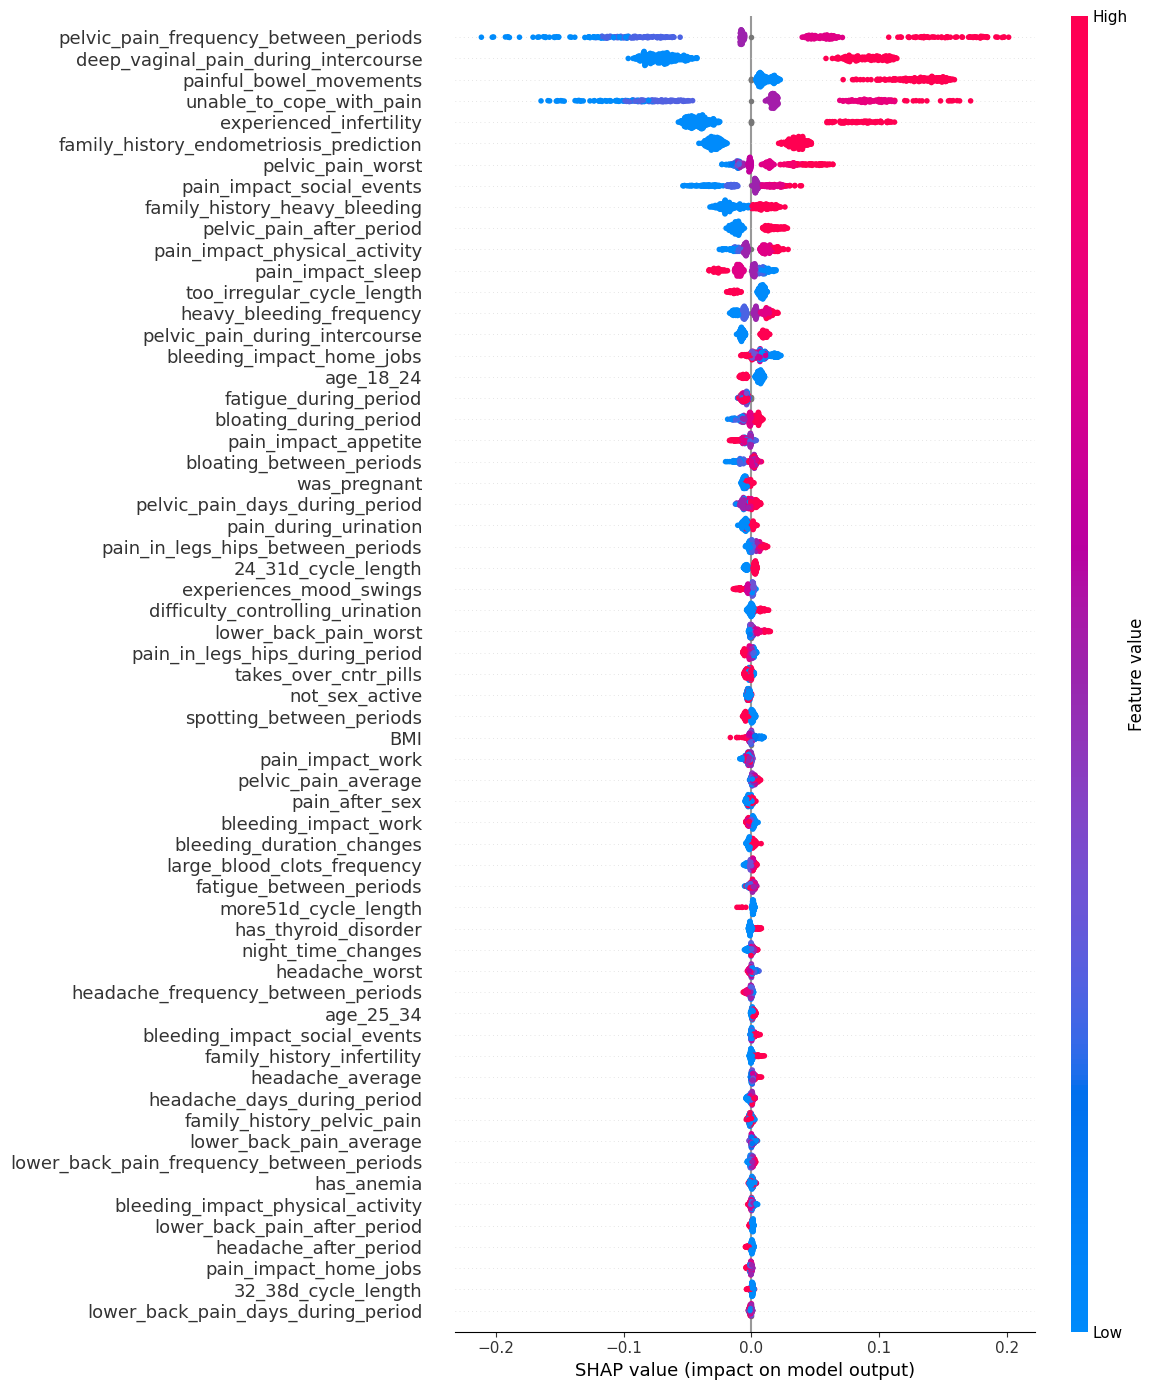

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_train, plot_size=[12, 14], max_display=61)

In [ ]:
# save the feature importnace ranking by SHAP, used in nc_and_mbc_modelling.ipynb
shap_importance.to_csv("shap_importance_tabpfn.csv", index=False)

### Running TabPFN on SHAP rankings provided by different models

In [ ]:
# normalized_shap_table.csv is generated in nc_and_mbc_modelling.ipynb. Please generate and uploud it to the Colab environment
normalized_shap_table = pd.read_csv("/content/normalized_shap_table.csv", index_col='feature')

In [ ]:
 best_perf_model_rf_tabpfn_shap, X_test_set_rf_tabpfn_shap, best_f1_rf_tabpfn_shap, avg_folds_f1_tabpfn_rf_shap = run_tabPFN_on_top_features(X_train, y_train, X_test, list(normalized_shap_table['importance_by_RF_SHAP'].sort_values(ascending=False).index), min_features=7)

In [ ]:
best_perf_model_xgb_tabpfn_shap, X_test_set_xgb_tabpfn_shap, best_f1_xgb_tabpfn_shap, avg_folds_f1_tabpfn_xgb_shap = run_tabPFN_on_top_features(X_train, y_train, X_test, list(normalized_shap_table['importance_by_XGB_SHAP'].sort_values(ascending=False).index), min_features=7)

In [ ]:
best_perf_model_ada_tabpfn_shap, X_test_set_ada_tabpfn_shap, best_f1_ada_tabpfn_shap, avg_folds_f1_tabpfn_ada_shap = run_tabPFN_on_top_features(X_train, y_train, X_test, list(normalized_shap_table['importance_by_ADA_SHAP'].sort_values(ascending=False).index), min_features=7)

In [ ]:
best_perf_model_mlp_tabpfn_shap, X_test_set_mlp_tabpfn_shap, best_f1_mlp_tabpfn_shap, avg_folds_f1_tabpfn_mlp_shap = run_tabPFN_on_top_features(X_train, y_train, X_test, list(normalized_shap_table['importance_by_MLP_SHAP'].sort_values(ascending=False).index), min_features=7)

In [ ]:
best_perf_model_tabpfn_tabpfn_shap, X_test_set_tabpfn_tabpfn_shap, best_f1_tabpfn_tabpfn_shap, avg_folds_f1_tabpfn_tabpfn_shap = run_tabPFN_on_top_features(X_train, y_train, X_test,list(normalized_shap_table['importance_by_TABPFN_SHAP'].sort_values(ascending=False).index), min_features=7)

In [ ]:
best_perf_model_mean_tabpfn_shap, X_test_set_mean_tabpfn_shap, best_f1_mean_tabpfn_shap, avg_folds_f1_tabpfn_mean_shap = run_tabPFN_on_top_features(X_train, y_train, X_test, list(normalized_shap_table['mean_importance'].sort_values(ascending=False).index), min_features=7)

In [ ]:
# save the F1 score metrics across models; used in nc_and_mbc_modelling.ipynb

with open("avg_folds_f1_tabpfn_rf_shap", "wb") as fp:
  pickle.dump(avg_folds_f1_tabpfn_rf_shap, fp)

with open("avg_folds_f1_tabpfn_xgb_shap", "wb") as fp:
  pickle.dump(avg_folds_f1_tabpfn_xgb_shap, fp)

with open("avg_folds_f1_tabpfn_ada_shap", "wb") as fp:
  pickle.dump(avg_folds_f1_tabpfn_ada_shap, fp)

with open("avg_folds_f1_tabpfn_mlp_shap", "wb") as fp:
  pickle.dump(avg_folds_f1_tabpfn_mlp_shap, fp)

with open("avg_folds_f1_tabpfn_tabpfn_shap", "wb") as fp:
  pickle.dump(avg_folds_f1_tabpfn_tabpfn_shap, fp)

with open("avg_folds_f1_tabpfn_mean_shap", "wb") as fp:
  pickle.dump(avg_folds_f1_tabpfn_mean_shap, fp)

Reviewing how may features is required for tabPFN model to achieve the corresponding performance.

In [ ]:
tabpfns_X_test_set, tabpfns_perf_model, tabpfns_best_f1 = [X_test_set_rf_tabpfn_shap, X_test_set_xgb_tabpfn_shap,
                                                           X_test_set_ada_tabpfn_shap, X_test_set_mlp_tabpfn_shap,
                                                           X_test_set_tabpfn_tabpfn_shap, X_test_set_mean_tabpfn_shap], [best_perf_model_rf_tabpfn_shap, best_perf_model_xgb_tabpfn_shap,
                                                            best_perf_model_ada_tabpfn_shap, best_perf_model_mlp_tabpfn_shap,
                                                             best_perf_model_tabpfn_tabpfn_shap, best_perf_model_mean_tabpfn_shap], [best_f1_rf_tabpfn_shap, best_f1_xgb_tabpfn_shap, best_f1_ada_tabpfn_shap,
                                                              best_f1_mlp_tabpfn_shap, best_f1_tabpfn_tabpfn_shap, best_f1_mean_tabpfn_shap]

In [ ]:
shap_seq = ["Random Forest", "XGBoost", "AdaBoost", "MLP", "TabPFN", "Mean Overall"]

In [ ]:
counter = 0
for best_X_test_set, best_perf_model, best_f1 in zip(tabpfns_X_test_set, tabpfns_perf_model, tabpfns_best_f1):
    print(f"Best performing model on SHAP ranking of the {shap_seq[counter]}:")
    print(f"F1 score of {best_f1:.4f}.")
    print(f"Number of features: {best_X_test_set.shape[1]}\n")
    counter += 1

Best performing model on SHAP ranking of the Random Forest:
F1 score of 0.7522.
Number of features: 28

Best performing model on SHAP ranking of the XGBoost:
F1 score of 0.7681.
Number of features: 14

Best performing model on SHAP ranking of the AdaBoost:
F1 score of 0.7570.
Number of features: 14

Best performing model on SHAP ranking of the MLP:
F1 score of 0.7677.
Number of features: 6

Best performing model on SHAP ranking of the TabPFN:
F1 score of 0.7642.
Number of features: 13

Best performing model on SHAP ranking of the Mean Overall:
F1 score of 0.7560.
Number of features: 16



## Automatic Bias Correction Modelling

Load data with the features selected during Feature Selection stage, along with treatment variables.

In [ ]:
df_real = pd.read_csv(endo_data_path)

In [ ]:
selected_features = [
 'pelvic_pain_frequency_between_periods',
 'deep_vaginal_pain_during_intercourse',
 'painful_bowel_movements',
 'unable_to_cope_with_pain',
 'experienced_infertility',
 'family_history_endometriosis_prediction',
 'pelvic_pain_worst',
 'takes_hormones_for_pain',
 'takes_presc_painkillers',
 ]

In [ ]:
X_real = df_real[selected_features]
y_real = df_real["has_endometriosis"]

Define values of estimated treatment effects.

The ATEs are obtained under [causality_ates_endo.ipynb](https://colab.research.google.com/drive/1SSy3NmiqabCy_9D8wFIC4ct_xh1B5k5c#scrollTo=MJq75w1wIwm8).

In [ ]:
takes_hormones_for_pain_effect = 0.25709203848847795
takes_presc_painkillers = 0.20126422297752325

In [ ]:
ate_features = ['takes_hormones_for_pain', 'takes_presc_painkillers']

In [ ]:
X_datasets = [X_real.copy()]
effects = {
    'takes_hormones_for_pain': takes_hormones_for_pain_effect,
    'takes_presc_painkillers': takes_presc_painkillers
}

for X_dataset in X_datasets:
    for feature, effect in effects.items():
        X_dataset[f"{feature}_effect"] = X_dataset[feature] * effect
        X_dataset.drop(columns=[feature], inplace=True)

In [ ]:
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
X_train_real, X_test_real = impute_features(X_train_real, X_test_real)

In [ ]:
tabpfn_model_double_debiased, tabpfn_val_folds_double_debiased = cross_val_tabPFN(
    X_train_real, y_train_real, disp=True
)

Avg F1 Score: 0.7509687139697208
